In [4]:
import numpy as np
import pandas as pd
import itertools
import csv
import os

##############################
file_name_list = ['bc02', 'bc04']

for file_name in file_name_list: 
    directory = './data_' + file_name + '/'
    
    data_raw = pd.read_csv(directory + file_name + '_PyFit.csv', header=None)
    read_num_seq = np.array(data_raw, dtype=int)
    read_num_seq = np.array(read_num_seq[:,:4], dtype=int)
    
    idx_1 = np.where(np.sum(read_num_seq, axis=1)>=20)[0]
    idx_2 = np.where(np.sum(read_num_seq, axis=1)<20)[0]
    if len(idx_2) == 0:
        read_num_seq_filter = read_num_seq
    else:
        read_num_seq_filter = np.vstack((read_num_seq[idx_1,:], np.sum(read_num_seq[idx_2,:], axis=0)))    
    
    tempt = pd.DataFrame(read_num_seq_filter, dtype = int)
    tempt.to_csv(directory + 'fitmut_input_read_number_filtered.csv', index=False, header=False)


    ##############################
    tempt = pd.read_csv(directory + 'timepts.csv', low_memory=False, header=None)
    t_seq = np.array(tempt[0][:4], dtype = float)
    cell_depth_seq = np.array(tempt[1][:4], dtype = float)
    input_tempt = {'0':t_seq, '1':cell_depth_seq}
    tempt = list(itertools.zip_longest(*list(input_tempt.values())))
    with open(directory + 'fitmut_input_time_points.csv', 'w') as f:
        w = csv.writer(f)
        w.writerows(tempt)
        
    print(read_num_seq.shape, np.mean(read_num_seq, axis=0), t_seq)


(75676, 4) [ 3.07933823 33.34380781  8.91408108 13.44132882] [ 5. 37. 62. 99.]
(113109, 4) [28.28972054 18.24373834  3.42126621  8.85053356] [ 5. 37. 62. 99.]


In [ ]:
!python fitmut_v2_a_20210916.py -i ./data_bc02/fitmut_input_read_number_filtered.csv -t ./data_bc02/fitmut_input_time_points.csv -o bc02_v2_a
!python fitmut_v2_a_20210916.py -i ./data_bc04/fitmut_input_read_number_filtered.csv -t ./data_bc04/fitmut_input_time_points.csv -o bc04_v2_a


  0%|                                                    | 0/30 [00:00<?, ?it/s]

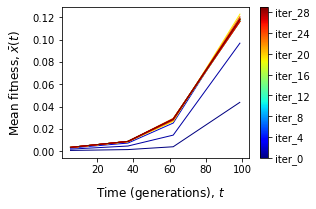

In [16]:
# double-check the convergence of the mean fitness
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.ticker as mticker

directory = './data_bc02/'
file_name = 'bc02_v2_a'

#directory = './data_bc04/'
#file_name = 'bc04_v2_a'


csv_input = pd.read_csv(directory + 'fitmut_input_time_points.csv', low_memory=False, header=None)
t_seq = np.array(csv_input[0][~pd.isnull(csv_input[0])], dtype=float)

csv_input = pd.read_csv('./' + file_name + '_Mean_fitness_Result.csv', low_memory=False)
x_mean_infer_array = np.array(csv_input).T
iter_num = x_mean_infer_array.shape[0]
t_seq_tile = np.tile(t_seq, (iter_num, 1))
segments = [np.column_stack([x, y]) for x, y in zip(t_seq_tile, x_mean_infer_array)]

##################################################
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_axes([0.25, 0.25, 0.65, 0.6])

lc = LineCollection(segments, array=np.arange(iter_num), cmap='jet', lw=1, label='inferred') #linestyle = solid|dashed|dashdot|dotted
ax.add_collection(lc)

cbar = fig.colorbar(lc)
cbar.ax.yaxis.set_major_locator(mticker.MaxNLocator(8))
ticks_loc = cbar.ax.get_yticks().tolist()
cbar.ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
label_format = 'iter_{:,.0f}'
cbar.ax.set_yticklabels([label_format.format(x) for x in ticks_loc])

x_lim_l, x_lim_r = t_seq[0], t_seq[-1]
x_lim_stepsize = (x_lim_r - x_lim_l)/20
y_lim_l, y_lim_r = 0, np.max(x_mean_infer_array)
y_lim_stepsize = (y_lim_r - y_lim_l)/20
plt.xlim(x_lim_l-x_lim_stepsize, x_lim_r+x_lim_stepsize)
plt.ylim(y_lim_l-y_lim_stepsize, y_lim_r+y_lim_stepsize)

fig.text(0.525, 0.11, r'Time (generations), $t$', ha='center', va='center', fontsize=12)
fig.text(0.12, 0.55, r'Mean fitness, $\bar{x}(t)$', ha='center', va='center', rotation='vertical', fontsize=12)
#plt.show()
plt.savefig('./Fig_x_mean_estimation_a1_' + file_name + '.pdf', transparent=True)


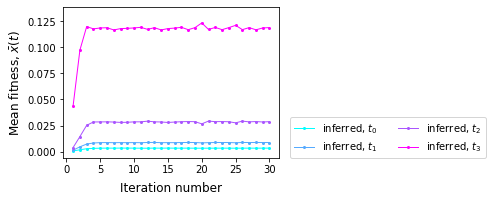

In [17]:
# double-check the convergence of the mean fitness
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm


csv_input = pd.read_csv(directory + 'fitmut_input_time_points.csv', low_memory=False, header=None)
t_seq = np.array(csv_input[0][~pd.isnull(csv_input[0])], dtype=float)

csv_input = pd.read_csv('./' + file_name + '_Mean_fitness_Result.csv', low_memory=False)
x_mean_infer_array = np.array(csv_input).T
iter_num, seq_num = x_mean_infer_array.shape
color_list = [cm.cool(x) for x in np.linspace(0, 1, seq_num)]

####################
fig = plt.figure(figsize=(7.5,3.5))
ax = fig.add_axes([0.15, 0.2, 0.4, 0.6])

for k in range(seq_num):
    plt.plot(np.arange(1,iter_num+1), x_mean_infer_array[:,k], '.-', color = color_list[k], linewidth=1, label=('inferred, $t_{%s}$' %k), markersize=4)

x_lim_l, x_lim_r = 1, iter_num
x_lim_stepsize = (x_lim_r - x_lim_l)/20
y_lim_l, y_lim_r = 0, np.max(x_mean_infer_array)
y_lim_stepsize = (y_lim_r - y_lim_l)/20
plt.xlim(x_lim_l-x_lim_stepsize, x_lim_r+x_lim_stepsize)
plt.ylim(y_lim_l-y_lim_stepsize, y_lim_r+2.5*y_lim_stepsize)

fig.text(0.35, 0.08, r'Iteration number', ha='center', va='center', fontsize=12)
fig.text(0.06, 0.5, r'Mean fitness, $\bar{x}(t)$', ha='center', va='center', rotation='vertical', fontsize=12)
plt.legend(loc=(1.05, 0), ncol=2)
#plt.show()
plt.savefig('./Fig_x_mean_estimation_a2_' + file_name + '.pdf', transparent=True)



In [18]:
import numpy as np
import pandas as pd
import os

threshold_value = 0

tempt = pd.read_csv('./' + file_name + '_MutSeq_Result.csv', low_memory=False)
s_inferred = np.array(tempt['Mutation_Fitness'], dtype=float)
tau_inferred = np.array(tempt['Establishment_Time'], dtype=float)
likelihood_array = np.array(tempt['Likelihood_Log'], dtype=float)
idx_adaptive_inferred = np.where(likelihood_array > threshold_value)[0]
idx_neutral_inferred = np.where(likelihood_array <= threshold_value)[0]
s_inferred[idx_neutral_inferred] = 0
tau_inferred[idx_neutral_inferred] = 0

tempt = pd.DataFrame(s_inferred)
tempt.to_csv(directory + 'fig_input_x_' + file_name + '.csv', index=False, header=False)


result_output = {'Mutation_Fitness': s_inferred,
                 'Establishment_Time': tau_inferred}
    
tempt = list(itertools.zip_longest(*list(result_output.values())))
with open(file_name + '_Estimated_Fitness_and_Establishment_Time.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(result_output.keys())
    w.writerows(tempt)


print(len(idx_adaptive_inferred))

# generate trajectory plot
os.system('python ./figtrajectory_v1_20210910.py -i ' + directory + 'fitmut_input_read_number_filtered.csv -t ' + directory + 'fitmut_input_time_points.csv -c ' + directory + 'fig_input_x_' + file_name + '.csv -o' + file_name)


1772


0

<ipython-input-15-80bbb7eb9970>:47: ComplexWarning: Casting complex values to real discards the imaginary part
  mu_inferred[k] = x/s_delta


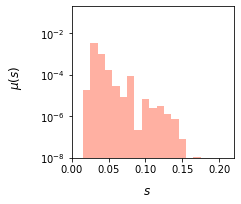

In [15]:
import numpy as np
import pandas as pd
from scipy.special import lambertw
import matplotlib.pyplot as plt
from scipy.stats import uniform


threshold_value = 0

tempt = pd.read_csv(file_name + '_MutSeq_Result.csv', low_memory=False)
s_inferred = np.array(tempt['Mutation_Fitness'], dtype=float)
tau_inferred = np.array(tempt['Establishment_Time'], dtype=float)
likelihood_array = np.array(tempt['Likelihood_Log'], dtype=float)
idx_adaptive_inferred = np.where(likelihood_array > threshold_value)[0]
x_mean = np.array(tempt['Mean_Fitness'][~pd.isnull(tempt['Mean_Fitness'])], dtype=float)

idx_adaptive = idx_adaptive_inferred
s_inferred = s_inferred[idx_adaptive]
tau_inferred = tau_inferred[idx_adaptive]


csv_input = pd.read_csv(directory + 'fitmut_input_time_points.csv', header=None)
t_seq = np.array(csv_input[0][~pd.isnull(csv_input[0])], dtype=float)
cell_num_seq = np.array(pd.read_csv(file_name + '_Cell_Number.csv', header=None), dtype=int) 
cell_num_seq_mutant = np.array(pd.read_csv(file_name + '_Cell_Number_Mutant_Estimated.csv', header=None), dtype=int) 

N_f = 1e12

#####
tau = t_seq[-1]
s_delta = 0.01
s_bin = np.arange(s_delta, 0.2, s_delta)
f_freq = np.zeros(len(s_bin)-1)
for k in range(len(s_bin)-1):
    idx = [idx_adaptive[i] for i in range(len(s_inferred)) if (s_bin[k] <= s_inferred[i] < s_bin[k+1]) and tau_inferred[i]<=tau]
    if idx:
        f_freq[k] = np.sum(cell_num_seq_mutant[idx, -1])/np.sum(cell_num_seq[:,-1])

s_array = (s_bin[:-1] + s_bin[1:])/2
mu_inferred = np.zeros(len(s_array))
for k in range(len(s_array)):
    s = s_array[k]
    a = s/(1+s*np.log(N_f))
    #b = f_freq[k]/(1+s*np.log(N_f)) #wrong formular (in original paper's supplymentary)
    b = f_freq[k]/(1+s*np.log(N_f))*np.exp(-s*tau)*s
    x = np.exp(lambertw(b/a*np.exp(1/a)) - 1/a)
    mu_inferred[k] = x/s_delta
    
    
######################################################################
fig = plt.figure(figsize=(6,3.5))
ax = fig.add_axes([0.25, 0.25, 0.375, 0.6])
l1 = plt.bar(s_bin[:-1], mu_inferred, width=s_delta, alpha=0.5, align='center', color='tomato')
plt.xlim(0,0.22)
plt.yscale('log')
plt.ylim(1e-8,2e-1)
fig.text(0.425, 0.12, r'$s$', ha='center', va='center', fontsize=12)
fig.text(0.12, 0.57, r'$\mu(s)$', ha='center', va='center', rotation='vertical', fontsize=12)
#plt.savefig('./Fig_dfe_' + file_name + '.pdf', transparent=True)
plt.savefig('./SupplementaryFigure13' + file_name + '.pdf', transparent=True)
plt.savefig('./SupplementaryFigure13' + file_name + '.png', transparent=True)